In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

import EoN

## Face to face interactions

También está disponible la versión de los mismos datasets [pero solo de co-localización](http://www.sociopatterns.org/datasets/co-location-data-for-several-sociopatterns-data-sets/)

In [2]:
df_1 = pd.read_csv('data/oficina.dat', sep=' ', header=None, names=['t', 'source', 'target']).drop(columns=['t'])
df_1.head(3)

,source,target
0,492,938
1,267,272
2,181,826


In [3]:
df_1['interaction'] = 1

In [4]:
df_1[df_1['source'] == 29]

,source,target,interaction
131,29,271,1
156,29,95,1
175,29,79,1
205,29,56,1
206,29,56,1
...,...,...,...
8954,29,791,1
9403,29,662,1
9406,29,791,1
9407,29,213,1


In [5]:
df_multi = df_1.groupby(by=['source', 'target']).count()
df_multi.head(3)

interaction
source target             
15     29                2
       95               80
       123              37

In [6]:
df_edge = df_multi.reset_index(level=[0,1])

In [7]:
g = nx.from_pandas_edgelist(df_edge, source='source', target='target', edge_attr='interaction')
g.name = 'office interactions'

In [8]:
g

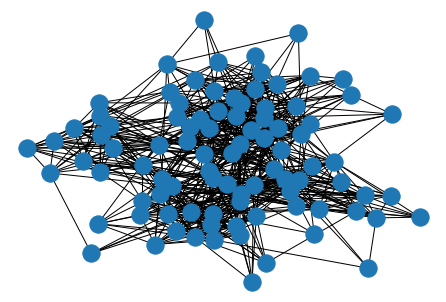

In [9]:
nx.draw(g)

In [10]:
print(nx.info(g))

Name: office interactions
Type: Graph
Number of nodes: 92
Number of edges: 755
Average degree:  16.4130


In [11]:
nx.set_node_attributes(g, pd.read_csv('data/atributes_office.txt', sep='\s+', header=None, index_col=0).to_dict()[1], name='department')

In [12]:
pd.factorize(list(nx.get_node_attributes(g,'department').values()))

(array([0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 0, 2, 0, 0, 0, 0, 0, 4, 0, 3, 0, 4, 0, 3, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 0, 1, 0, 0, 1, 0, 1, 2,
        2, 2, 2, 2, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 2, 4,
        0, 2, 0, 2], dtype=int64),
 array(['DSE', 'DISQ', 'DMCT', 'SRH', 'SFLE'], dtype=object))

In [13]:
pos = nx.drawing.layout.kamada_kawai_layout(g, dist=None)

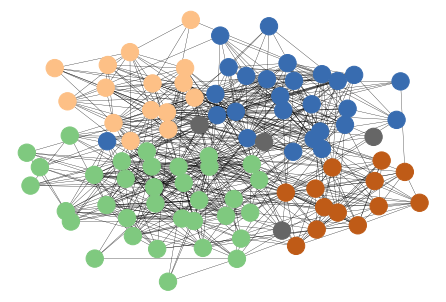

In [58]:
# plt.figure(figsize=(18,18))

nx.draw(g, node_color = pd.factorize(list(nx.get_node_attributes(g,'department').values()))[0]
       # , vmin=0, vmax=4, cmap = plt.cm.get_cmap('rainbow')
       , pos=pos, width=0.3, cmap=plt.cm.Accent)

plt.savefig("plot.png", dpi=500)

In [15]:
nx.info(g)

'Name: office interactions\nType: Graph\nNumber of nodes: 92\nNumber of edges: 755\nAverage degree:  16.4130'

In [16]:
g.nodes()[213]

{'department': 'SFLE'}

In [17]:
max_interaction = 0
for e in g.edges(data=True):
    origin, target, info = e
    if info['interaction'] > max_interaction:
        max_interaction = info['interaction']

In [18]:
for e in g.edges(data=True):
    origin, target, info = e
    real = g.edges[(origin, target)]['interaction']
    g.edges[(origin, target)]['interaction_normalized'] = real / max_interaction

In [19]:
pesos = [bueno for _, __, bueno in g.edges(data='interaction')]
p = np.array(pesos)

In [20]:
coso = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='kmeans')
coso2 = coso.fit_transform(p.reshape(-1, 1))

In [21]:
for i, e in enumerate(g.edges(data=True)):
    origin, target, info = e
    g.edges[(origin, target)]['interaction_bins'] = coso2[i][0]+0.01 / 7

In [22]:
coso2[5][0]

0.0

(array([585., 106.,  32.,   0.,  13.,  12.,   0.,   4.,   2.,   1.]),
 array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01]),
 <BarContainer object of 10 artists>)

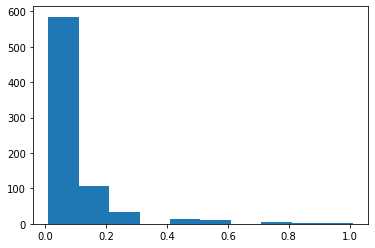

In [35]:
plt.hist((coso2/7)+0.01)

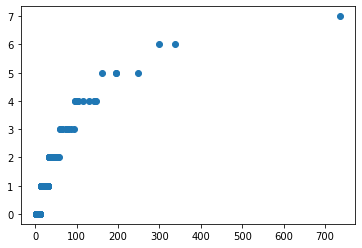

In [23]:
plt.scatter(p, coso2)

In [29]:
tau = 1
gamma = 1/6

# tau number: transmission rate per edge
# gamma number: recovery rate per node


sim = EoN.fast_SIR(g, tau, gamma,  
             transmission_weight='interaction_bins', return_full_data=True)

MovieWriter ffmpeg unavailable; using Pillow instead.


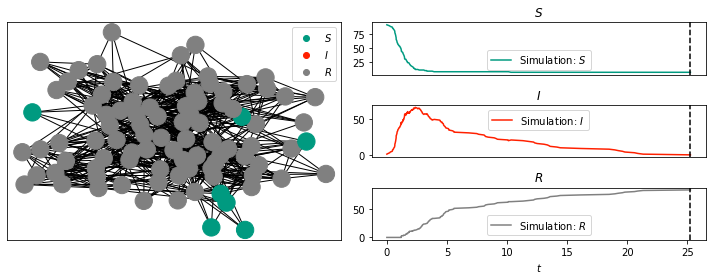

In [30]:
ani = sim.animate()
ani.save('animacion5.gif')

In [45]:
g2 = g.copy()

In [46]:
# sorted(g2.degree(weight='interaction_bins'), key=lambda x: x[1], reverse=True)

In [47]:
g2.remove_nodes_from([311, 123, 271, 63, 95, 153, 150, 194])

In [54]:
tau = 1
gamma = 1/6

# tau number: transmission rate per edge
# gamma number: recovery rate per node


sim2 = EoN.fast_SIR(g2, tau, gamma,  
             transmission_weight='interaction_bins', return_full_data=True)

MovieWriter ffmpeg unavailable; using Pillow instead.


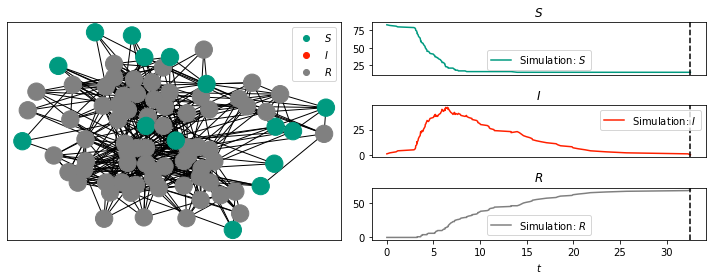

In [55]:
ani2 = sim2.animate()
ani2.save('animacion_edges_removed.gif')

# Simulating SARS-COV-2 in a office network

## Introduction. 

The world is currently plagued by a pandemic that as of today (July 2020), accumulates 238 thousand deaths and 2.75 million deaths [according to official figures reported by the Mexican Government](https://datos.covid-19.conacyt.mx). 

Just over a year after the first case detected in the country, [which dates back to February 27, 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7250750/), many things have changed in terms of our understanding of the disease and the measures that can be implemented to mitigate it.

Among these measures, the creation and subsequent application of a vaccine that could eradicate the epidemic was the most promising, however, months after the application of millions of vaccines worldwide, and [with 32% of the Mexican population with at least one dose, and 18% fully vaccinated](https://ourworldindata.org/coronavirus/country/mexico#vaccinations), the pandemic does not seem to have receded.

Out of multiple causes for this problem, one of them could be described as ["Fully vaccinated doesn't mean immune to COVID-19](https://health.clevelandclinic.org/can-vaccinated-people-transmit-covid-19-to-others/)", which in a few words means that those who have been vaccinated can still contract the virus and spread it to other people, although as far as we know, at a lower rate.

So far, there is still no certainty as to how this phenomenon would be affected by the appearance of variants of the virus, such as the delta variant, which, [according to experts](https://www.elfinanciero.com.mx/salud/2021/07/08/variante-delta-de-covid-sera-predominante-en-mexico-lo-que-resta-de-2021-alerta-epidemiologa/), would be the predominant one in the country for the rest of the year, due to its high level of contagion.

Even with all this situation, many companies within the Mexican territory have begun to abandon the famous "home office" to return to work in offices (if at some point the company adopted this form of remote work).

With all this in mind, it is important to analyze how a virus such as covid-19 could spread in an office environment, where people usually spend a lot of time together in closed spaces and without adequate ventilation systems, as well as the high level of face-to-face interactions that usually take place in these locations.

To perform the simulations, a [network of contacts in a work environment](http://www.sociopatterns.org/datasets/test/) will be used, which recorded face-to-face interactions in office buildings in France in 2015.

These interactions were collected using special devices, which took as valid an interaction when two individuals were at a minimum distance and looking at each other.

Below is a graph of the network, where each color indicates a department within the company.

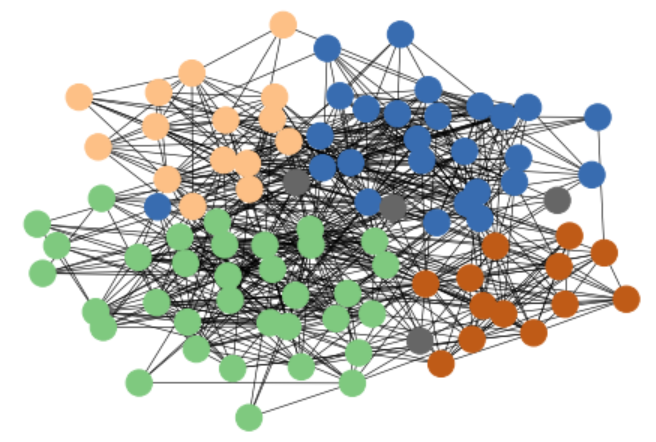

The network has 92 nodes and 755 edges.

It is a weighted network, and the weights, which correspond to the number of times a face-to-face contact between individuals was recorded, was recalculated using binning techniques to assign one of 8 values between 0 and 1 to the weights linearly separated by $\frac{1}{8}$ spaces. 

Because of this, records with few interactions had a weight very close to 0, and  records with a lot interactions had a weight close to 1, and the rest of the values were assigned to one of the 6 bins between those two numbers.

## Model. 

There are different models that can be applied to represent an epidemic; however, due to the characteristics previously mentioned, an S.I.R. (Susceptible, Infected and Recovered) model will be used.

This model is [described by differential equations,](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model) and is usually applied in the case of not knowing the general structure of the network, as is often the case when trying to predict the behavior of an epidemic in large populations.

However, this model can also be [implemented on networks](http://systems-sciences.uni-graz.at/etextbook/networks/sirnetwork.html) with an a priori known structure, where the nodes represent individuals and each edge represents interactions between them.
At each step of the simulation there is a probability that an infected node will infect a susceptible node, as well as the probability that the infected node will be cured (or die in the worst case) and become recovered.

In both cases, the modeling result will depend on two variables:

- $\beta$: transmission rate, and will affect how likely it is that an individual will contract the disease (or the probability that an infected person will infect a susceptible person).
- $\gamma$: recovery rate, and will affect how likely it is that an individual will go from infected to recovered.

**[According to the latest reports](https://www.forbes.com/sites/williamhaseltine/2021/07/13/the-delta-dilemma-loosening-covid-19-controls-at-a-time-of-increased-danger/?sh=7b5d86372750) on the Delta variant of the coronavirus, the $r_{0}$ is estimated to be between 4 and 9, compared to ~2.7 that was considered for the original variant.**

**In the SIR model, [$r_{0}$ equals $\frac{\beta}{\gamma}$](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6291769/).**

![sir_image](https://covid19.uclaml.org/figures/sir_illu.png)

In this simulation, the states will be defined as follows:

- Susceptible: refers to those individuals who have never contracted the disease. This group also includes vaccinated individuals, since, as mentioned above, they are still susceptible to contracting the disease and becoming contagious.
- Infected: as its name indicates, this group includes those persons who have the active virus in their organism and are therefore capable of spreading the disease. Within this group we can distinguish symptomatic and asymptomatic people. Asymptomatic people are would normally be isolated from the network, but we will not take this case into account due to complexity issues. Nevertheless, assuming that most of the people in the office either vaccinated or young, it is expected to have a low portion of symptomatic infected people. 
- Recovered: in this group are those people who have already had the disease and, as far as is known, are not capable of contracting the disease or spreading it again.

## Results. 
After running the simulation, it is possible to see how the pandemic would spread within the network in approximately less than a month, assuming that each timestep corresponds to one day.

As can be seen in the graph of infected individuals, in the first 5 days there would be a large peak, which would cause practically all personnel to be infected during the first week after the first infected person.

It is important to emphasize that the SIR model does not take into account the incubation time of the virus (which in the case of covid-19 could extend [up to 14 days, with an average time of 4 to 5 days](https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html), as other models such as [SIIR](https://onlinelibrary.wiley.com/doi/10.1002/jgf2.382) do, so the results shown in the graph would correspond to the worst possible scenario where each person who contracts the virus incubates it in such a way that on the same day he or she can infect other people.

In any case, the results are still useful because they show that in a network where there are so many interactions between nodes, the chances of contagion are very high, thus demonstrating the importance of the use of masks and social distancing.

In terms of network analysis, another measure that could help to mitigate the spread of the virus could be the identification of the nodes with the highest degree, since they can act as superspreaders  within the network.